In [104]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.svm import SVC
import time
import spacy
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import FeatureUnion
import warnings
warnings.filterwarnings('ignore')

# Download necessary NLTK resources
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

In [106]:

#--------------------------------------------------------------#
# SECTION 1: DATA LOADING AND EXPLORATION
#--------------------------------------------------------------#
print("SECTION 1: DATA LOADING AND EXPLORATION")

# Load the dataset
with open('C:/Users/sherm/Desktop/NLP/Appliances.jsonl', 'r') as f:
    appliances = [json.loads(line) for line in f]

df = pd.DataFrame(appliances)
print(f"Dataset shape: {df.shape}")




SECTION 1: DATA LOADING AND EXPLORATION
Dataset shape: (2128605, 10)


In [107]:
from sklearn.model_selection import StratifiedShuffleSplit

stratify_col = 'rating'

# Ensure the column exists
if stratify_col in df.columns:
    split = StratifiedShuffleSplit(n_splits=1, test_size=2500, random_state=50)
    for _, sample_idx in split.split(df, df[stratify_col]):
        stratified_df = df.iloc[sample_idx]
    print(f"Stratified sample shape: {stratified_df.shape}")
    print(f"Class distribution in sample:\n{stratified_df[stratify_col].value_counts(normalize=True)}")
else:
    print(f"Column '{stratify_col}' not found in DataFrame.")

df = stratified_df

Stratified sample shape: (2500, 10)
Class distribution in sample:
rating
5.0    0.6980
1.0    0.1176
4.0    0.0980
3.0    0.0488
2.0    0.0376
Name: proportion, dtype: float64


<class 'pandas.core.frame.DataFrame'>
Index: 2500 entries, 152851 to 254346
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rating             2500 non-null   float64
 1   title              2500 non-null   object 
 2   text               2500 non-null   object 
 3   images             2500 non-null   object 
 4   asin               2500 non-null   object 
 5   parent_asin        2500 non-null   object 
 6   user_id            2500 non-null   object 
 7   timestamp          2500 non-null   int64  
 8   helpful_vote       2500 non-null   int64  
 9   verified_purchase  2500 non-null   bool   
dtypes: bool(1), float64(1), int64(2), object(6)
memory usage: 197.8+ KB


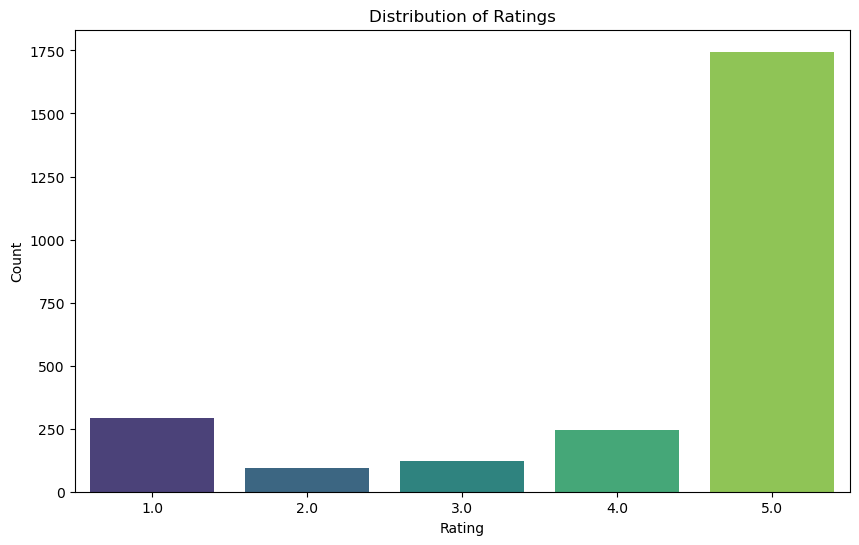


Summary statistics:
          timestamp  helpful_vote
count  2.500000e+03   2500.000000
mean   1.562549e+12      0.896800
std    8.531899e+10      6.583699
min    1.225734e+12      0.000000
25%    1.506496e+12      0.000000
50%    1.578183e+12      0.000000
75%    1.627752e+12      0.000000
max    1.693169e+12    193.000000


In [108]:
# Display basic information about the dataset
df.info()

# Convert rating to categorical
df['rating'] = df['rating'].astype('object')

# Plot the distribution of ratings
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='rating', palette='viridis')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


# Get summary statistics
print("\nSummary statistics:")
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 2500 entries, 152851 to 254346
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   rating             2500 non-null   object
 1   title              2500 non-null   object
 2   text               2500 non-null   object
 3   images             2500 non-null   object
 4   asin               2500 non-null   object
 5   parent_asin        2500 non-null   object
 6   user_id            2500 non-null   object
 7   timestamp          2500 non-null   int64 
 8   helpful_vote       2500 non-null   int64 
 9   verified_purchase  2500 non-null   bool  
dtypes: bool(1), int64(2), object(7)
memory usage: 197.8+ KB


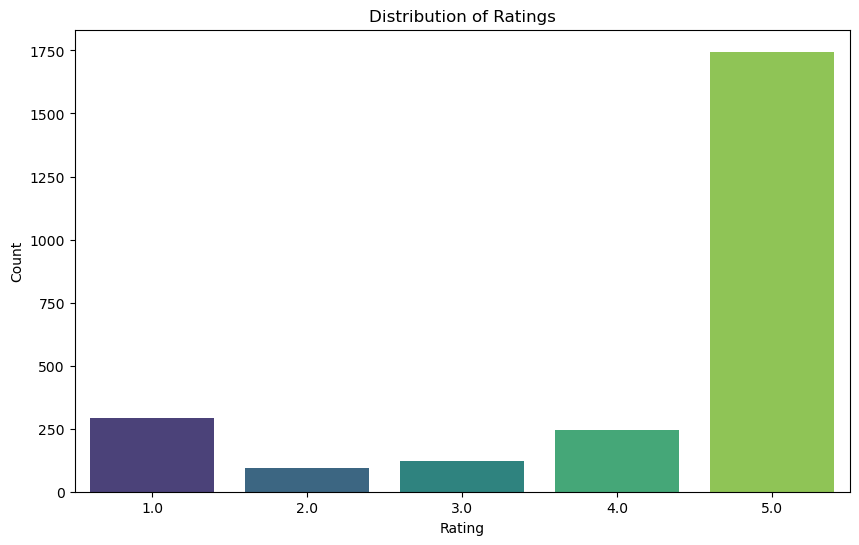


Summary statistics:
          timestamp  helpful_vote
count  2.500000e+03   2500.000000
mean   1.562549e+12      0.896800
std    8.531899e+10      6.583699
min    1.225734e+12      0.000000
25%    1.506496e+12      0.000000
50%    1.578183e+12      0.000000
75%    1.627752e+12      0.000000
max    1.693169e+12    193.000000


In [109]:
# Display basic information about the dataset
df.info()

# Convert rating to categorical
df['rating'] = df['rating'].astype('object')

# Plot the distribution of ratings
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='rating', palette='viridis')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


# Get summary statistics
print("\nSummary statistics:")
print(df.describe())


SECTION 2: ANALYZING REVIEWS BY PRODUCTS AND USERS


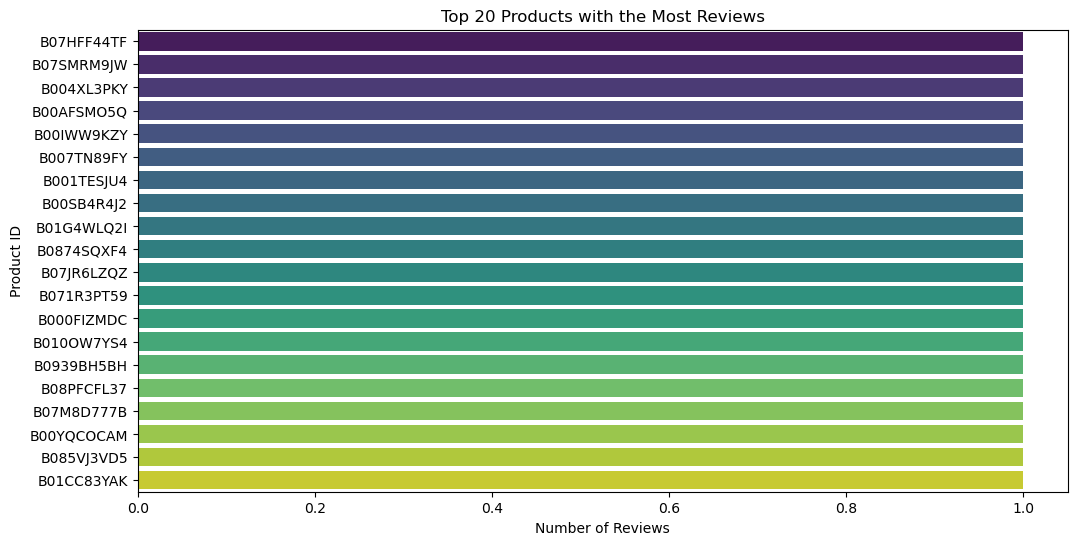

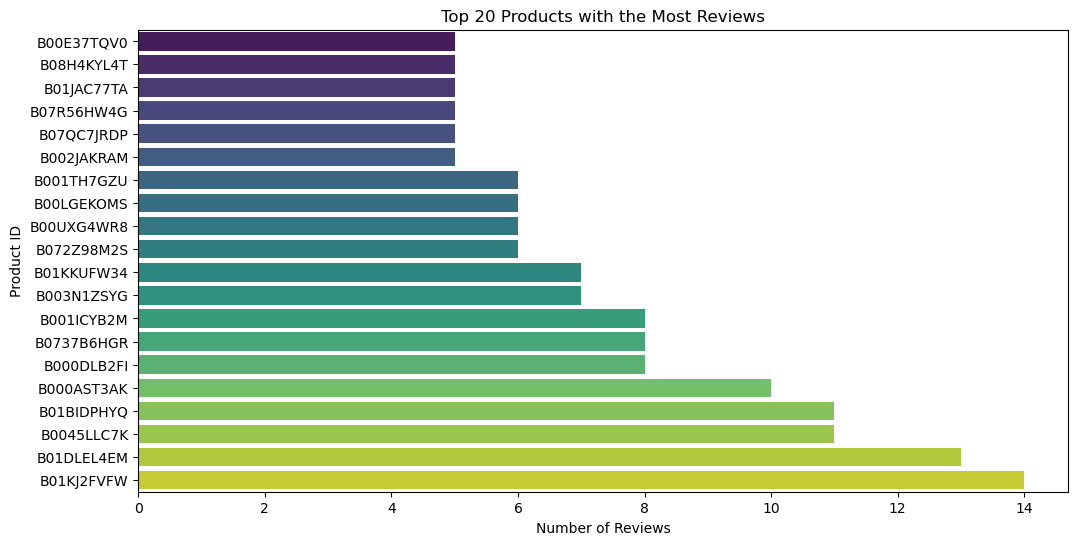

In [110]:
#--------------------------------------------------------------#
# SECTION 2: ANALYZING REVIEWS BY PRODUCTS AND USERS
#--------------------------------------------------------------#
print("\nSECTION 2: ANALYZING REVIEWS BY PRODUCTS AND USERS")

# Distribution of the number of reviews per product
reviews_per_product = df['asin'].value_counts().reset_index()
reviews_per_product.columns = ['product_id', 'num_reviews']
reviews_per_product = reviews_per_product.sort_values(by='num_reviews', ascending=False)

# Get top 20 products
top_20_products = reviews_per_product.tail(20)
plt.figure(figsize=(12, 6))
sns.barplot(data=top_20_products, x='num_reviews', y='product_id', palette='viridis')
plt.title('Top 20 Products with the Most Reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('Product ID')
plt.show()





reviews_per_product = df['asin'].value_counts().reset_index()
reviews_per_product.columns = ['product_id', 'num_reviews']
reviews_per_product = reviews_per_product.sort_values(by='num_reviews', ascending=True)

# Get top 20 products
top_20_products = reviews_per_product.tail(20)
plt.figure(figsize=(12, 6))
sns.barplot(data=top_20_products, x='num_reviews', y='product_id', palette='viridis')
plt.title('Top 20 Products with the Most Reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('Product ID')
plt.show()



# Distribution of reviews per user
reviews_per_user = df['user_id'].value_counts().reset_index()
reviews_per_user.columns = ['user_id', 'num_reviews']
reviews_per_user = reviews_per_user.sort_values(by='num_reviews', ascending=True)




SECTION 3: WORD CLOUD VISUALIZATION BY SENTIMENT


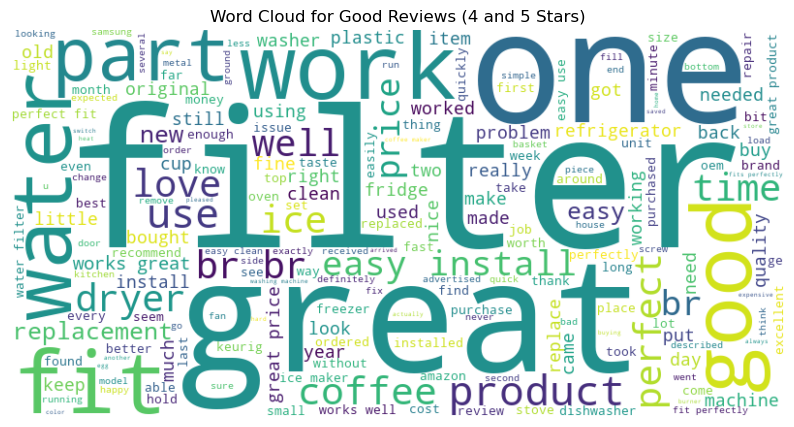

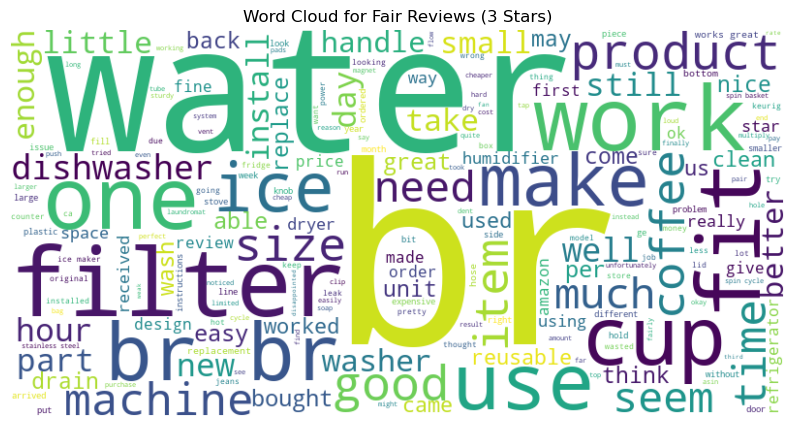

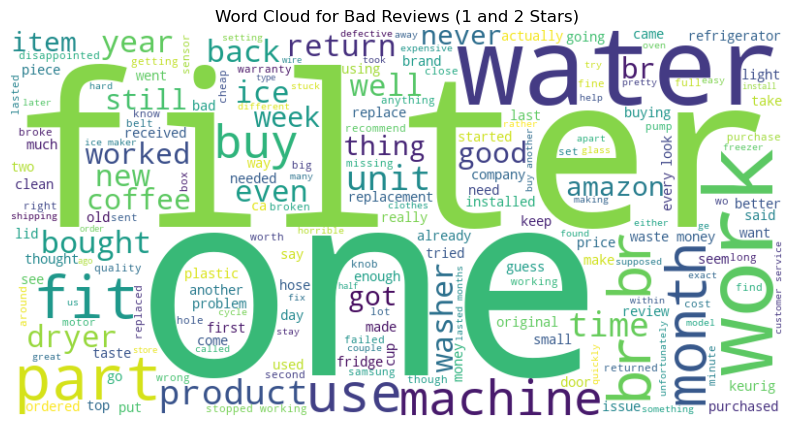

In [111]:

#--------------------------------------------------------------#
# SECTION 3: WORD CLOUD VISUALIZATION BY SENTIMENT
#--------------------------------------------------------------#
print("\nSECTION 3: WORD CLOUD VISUALIZATION BY SENTIMENT")

# Categorize reviews by rating
good_reviews = df[df['rating'].isin([4, 5])]['text'].tolist()
fair_reviews = df[df['rating'] == 3]['text'].tolist()
bad_reviews = df[df['rating'].isin([1, 2])]['text'].tolist()

# Get stopwords
stop_words = set(stopwords.words('english'))

# Create word cloud for good reviews
good_reviews_text = ' '.join(good_reviews)
good_reviews_tokens = word_tokenize(good_reviews_text.lower())
good_reviews_tokens = [word for word in good_reviews_tokens if word.isalpha() and word not in stop_words]
good_reviews_text = ' '.join(good_reviews_tokens)

wordcloud_good = WordCloud(width=800, height=400, background_color='white').generate(good_reviews_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_good, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Good Reviews (4 and 5 Stars)')
plt.show()

# Create word cloud for fair reviews
fair_reviews_text = ' '.join(fair_reviews)
fair_reviews_tokens = word_tokenize(fair_reviews_text.lower())
fair_reviews_tokens = [word for word in fair_reviews_tokens if word.isalpha() and word not in stop_words]
fair_reviews_text = ' '.join(fair_reviews_tokens)

wordcloud_fair = WordCloud(width=800, height=400, background_color='white').generate(fair_reviews_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_fair, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Fair Reviews (3 Stars)')
plt.show()

# Create word cloud for bad reviews
bad_reviews_text = ' '.join(bad_reviews)
bad_reviews_tokens = word_tokenize(bad_reviews_text.lower())
bad_reviews_tokens = [word for word in bad_reviews_tokens if word.isalpha() and word not in stop_words]
bad_reviews_text = ' '.join(bad_reviews_tokens)

wordcloud_bad = WordCloud(width=800, height=400, background_color='white').generate(bad_reviews_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_bad, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Bad Reviews (1 and 2 Stars)')
plt.show()


In [112]:

#--------------------------------------------------------------#
# SECTION 4: DATA PREPARATION FOR SENTIMENT ANALYSIS
#--------------------------------------------------------------#
print("\nSECTION 4: DATA PREPARATION FOR SENTIMENT ANALYSIS")

# Map ratings to sentiment labels
df['sentiment'] = df['rating'].apply(lambda x: 'positive' if x in [4, 5] else ('neutral' if x == 3 else 'negative'))
#df['sentiment'].drop('neutral')

# Print class distribution
sentiment_counts = df['sentiment'].value_counts()
print("\nSentiment distribution:")
print(sentiment_counts)
print(f"Percentage of positive: {sentiment_counts['positive']/len(df)*100:.2f}%")
#print(f"Percentage of neutral: {sentiment_counts['neutral']/len(df)*100:.2f}%")
print(f"Percentage of negative: {sentiment_counts['negative']/len(df)*100:.2f}%")

# Split data into training and testing sets
X = df['text']
y = df['sentiment']

# Use stratified sampling to maintain class distribution
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, test_index in split.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

print(f"\nTraining set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")



SECTION 4: DATA PREPARATION FOR SENTIMENT ANALYSIS

Sentiment distribution:
sentiment
positive    1990
negative     388
neutral      122
Name: count, dtype: int64
Percentage of positive: 79.60%
Percentage of negative: 15.52%

Training set size: 1750
Testing set size: 750


In [113]:
df['sentiment'].value_counts()

sentiment
positive    1990
negative     388
neutral      122
Name: count, dtype: int64

In [114]:
df = df[df['sentiment'] != 'neutral']


In [115]:
df['sentiment'].value_counts()

sentiment
positive    1990
negative     388
Name: count, dtype: int64

In [116]:
df.shape

(2378, 11)


SECTION 5: BASELINE MODEL - LOGISTIC REGRESSION
Training Logistic Regression model...

Logistic Regression Performance:
              precision    recall  f1-score   support

    negative       0.78      0.28      0.41       116
     neutral       0.00      0.00      0.00        37
    positive       0.83      0.99      0.90       597

    accuracy                           0.83       750
   macro avg       0.54      0.42      0.44       750
weighted avg       0.78      0.83      0.78       750

Accuracy: 0.8293333333333334


<Figure size 1000x800 with 0 Axes>

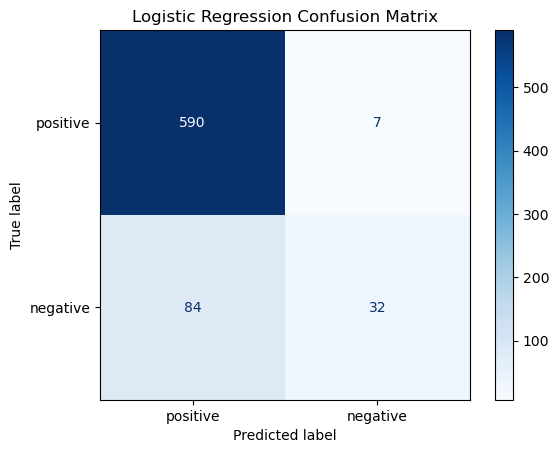

In [117]:

#--------------------------------------------------------------#
# SECTION 5: BASELINE MODEL - LOGISTIC REGRESSION
#--------------------------------------------------------------#
print("\nSECTION 5: BASELINE MODEL - LOGISTIC REGRESSION")

# Create and train the logistic regression pipeline
lr_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

print("Training Logistic Regression model...")
lr_pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred_lr = lr_pipeline.predict(X_test)

# Evaluate the model
print("\nLogistic Regression Performance:")
print(classification_report(y_test, y_pred_lr))
print("Accuracy:", accuracy_score(y_test, y_pred_lr))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_lr, labels=['positive', 'negative'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['positive', 'negative'])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

In [118]:

#--------------------------------------------------------------#
# SECTION 6: ASPECT-BASED SENTIMENT ANALYSIS
#--------------------------------------------------------------#
print("\nSECTION 6: ASPECT-BASED SENTIMENT ANALYSIS")

# Function to extract aspects (features) from reviews
def extract_aspects(reviews, top_n=20):
    """
    Extract common product aspects from reviews using frequency-based approach with NLTK
    
    Args:
        reviews: List of review texts
        top_n: Number of top aspects to extract
        
    Returns:
        List of most common aspects/features
    """
    print("Extracting aspects from reviews...")
    
    # Load spaCy model for better noun phrase extraction
    try:
        nlp = spacy.load('en_core_web_sm')
    except:
        # If model is not available, download it
        import subprocess
        subprocess.run(['python', '-m', 'spacy', 'download', 'en_core_web_sm'])
        nlp = spacy.load('en_core_web_sm')
    
    # Dictionary of product features commonly found in appliance reviews
    appliance_features = [
        'price', 'quality', 'value', 'size', 'weight', 'noise', 'power',
        'performance', 'design', 'durability', 'reliability', 'efficiency',
        'warranty', 'installation', 'cleaning', 'maintenance', 'temperature',
        'settings', 'controls', 'display', 'buttons', 'interface', 'features',
        'capacity', 'speed', 'cord', 'color', 'material', 'ease', 'convenience'
    ]
    
    # Extract noun phrases using spaCy
    all_aspects = []
    sample_size = min(len(reviews), 5000)  # Process a sample for efficiency
    
    for review in reviews[:sample_size]:
        if not isinstance(review, str) or len(review.strip()) == 0:
            continue
            
        doc = nlp(review.lower())
        
        # Extract noun chunks (potential aspects)
        for chunk in doc.noun_chunks:
            # Check if it contains any of our predefined appliance features
            for feature in appliance_features:
                if feature in chunk.text:
                    all_aspects.append(feature)
                    break
            
        # Also look for direct mentions of features
        for feature in appliance_features:
            if feature in review.lower():
                all_aspects.append(feature)
    
    # Count frequency of aspects
    aspect_counter = Counter(all_aspects)
    
    # Get top N most common aspects
    top_aspects = [aspect for aspect, count in aspect_counter.most_common(top_n)]
    
    print(f"Top {len(top_aspects)} aspects extracted: {', '.join(top_aspects)}")
    return top_aspects

# Function to analyze sentiment for each aspect in reviews
def analyze_aspect_sentiment(reviews, aspects):
    """
    Determine sentiment for each aspect in each review
    
    Args:
        reviews: List of review texts
        aspects: List of aspects to analyze
        
    Returns:
        DataFrame with sentiment scores for each aspect in each review
    """
    print("Analyzing sentiment for each aspect...")
    
    # Initialize VADER sentiment analyzer
    analyzer = SentimentIntensityAnalyzer()
    
    # Create a DataFrame to store aspect sentiment scores
    aspect_sentiments = pd.DataFrame(index=range(len(reviews)))
    
    # Process each review
    for idx, review in enumerate(reviews):
        if not isinstance(review, str) or len(review.strip()) == 0:
            # Skip empty reviews or non-string values
            for aspect in aspects:
                aspect_sentiments.loc[idx, aspect] = 0
            continue
            
        # Split review into sentences
        sentences = re.split(r'[.!?]+', review.lower())
        
        # Initialize sentiment scores for each aspect in this review
        aspect_scores = {aspect: [] for aspect in aspects}
        
        # Check each sentence for aspects and sentiment
        for sentence in sentences:
            # Skip empty sentences
            if len(sentence.strip()) == 0:
                continue
                
            # Get sentiment score for the entire sentence
            sentence_sentiment = analyzer.polarity_scores(sentence)
            
            # Check for each aspect in the sentence
            for aspect in aspects:
                if aspect in sentence:
                    aspect_scores[aspect].append(sentence_sentiment['compound'])
        
        # Calculate average sentiment for each aspect in this review
        for aspect in aspects:
            if aspect_scores[aspect]:
                # If we found the aspect, use the average sentiment
                aspect_sentiments.loc[idx, aspect] = np.mean(aspect_scores[aspect])
            else:
                # If aspect not mentioned, set to 0 (neutral)
                aspect_sentiments.loc[idx, aspect] = 0
    
    return aspect_sentiments

# Function to create enhanced feature vectors
def create_enhanced_features(reviews, aspect_sentiments):
    """
    Combine TF-IDF features with aspect sentiment features
    
    Args:
        reviews: List of review texts
        aspect_sentiments: DataFrame of aspect sentiment scores
        
    Returns:
        Enhanced feature matrix
    """
    print("Creating enhanced feature vectors...")
    
    # Create TF-IDF features from review text
    tfidf = TfidfVectorizer(max_features=5000)
    tfidf_features = tfidf.fit_transform(reviews)
    
    # Convert aspect sentiments to numpy array
    aspect_features = aspect_sentiments.values
    
    # Standardize the aspect features
    scaler = StandardScaler()
    aspect_features_scaled = scaler.fit_transform(aspect_features)
    
    # Combine TF-IDF and aspect sentiment features
    enhanced_features = np.hstack((tfidf_features.toarray(), aspect_features_scaled))
    
    print(f"Enhanced feature matrix shape: {enhanced_features.shape}")
    return enhanced_features, tfidf



SECTION 6: ASPECT-BASED SENTIMENT ANALYSIS



SECTION 7: ENHANCED SVM MODEL WITH ASPECT-BASED SENTIMENT
Extracting aspects from reviews...
Top 10 aspects extracted: price, quality, size, value, ease, color, design, temperature, cleaning, installation
Processing training set:
Analyzing sentiment for each aspect...
Processing test set:
Analyzing sentiment for each aspect...
Creating enhanced feature vectors for training set...
Creating enhanced feature vectors...
Enhanced feature matrix shape: (1750, 4576)
Creating enhanced feature vectors for test set...
Training SVM model with aspect-enhanced features...
SVM model training completed in 63.26 seconds

SVM Model Performance with Aspect-Based Features:
              precision    recall  f1-score   support

    negative       0.47      0.61      0.53       116
     neutral       0.03      0.03      0.03        37
    positive       0.91      0.86      0.88       597

    accuracy                           0.78       750
   macro avg       0.47      0.50      0.48       750
weighted a

<Figure size 1000x800 with 0 Axes>

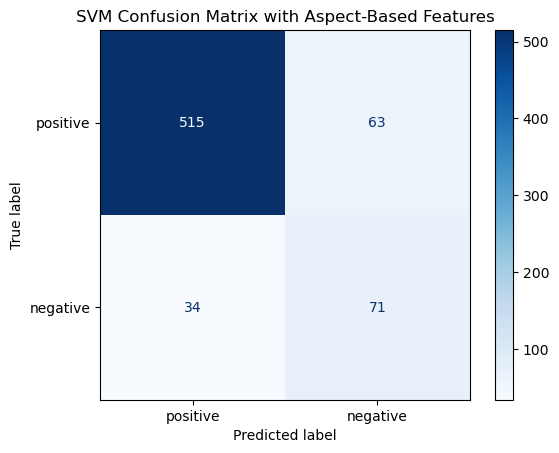

In [119]:

#--------------------------------------------------------------#
# SECTION 7: ENHANCED SVM MODEL WITH ASPECT-BASED SENTIMENT
#--------------------------------------------------------------#
print("\nSECTION 7: ENHANCED SVM MODEL WITH ASPECT-BASED SENTIMENT")

# Extract common aspects from the training set
top_aspects = extract_aspects(X_train.values, top_n=10)

# Analyze sentiment for each aspect in training and test sets
print("Processing training set:")
train_aspect_sentiments = analyze_aspect_sentiment(X_train.values, top_aspects)
print("Processing test set:")
test_aspect_sentiments = analyze_aspect_sentiment(X_test.values, top_aspects)

# Create enhanced feature vectors
print("Creating enhanced feature vectors for training set...")
X_train_enhanced, tfidf_vectorizer = create_enhanced_features(X_train.values, train_aspect_sentiments)
print("Creating enhanced feature vectors for test set...")
X_test_enhanced = np.hstack((
    tfidf_vectorizer.transform(X_test.values).toarray(), 
    StandardScaler().fit_transform(test_aspect_sentiments.values)
))

# Train SVM model with enhanced features
print("Training SVM model with aspect-enhanced features...")
svm_start_time = time.time()

# Create SVM model with balanced class weights to address imbalance
svm_model = SVC(
    kernel='linear',
    C=1.0,
    class_weight='balanced',
    probability=True,
    random_state=42
)

# Train the model
svm_model.fit(X_train_enhanced, y_train)

# Calculate training time
svm_training_time = time.time() - svm_start_time
print(f"SVM model training completed in {svm_training_time:.2f} seconds")

# Make predictions
svm_y_pred = svm_model.predict(X_test_enhanced)

# Evaluate SVM model
print("\nSVM Model Performance with Aspect-Based Features:")
print(classification_report(y_test, svm_y_pred))
print("Accuracy:", accuracy_score(y_test, svm_y_pred))

# Plot confusion matrix for SVM
plt.figure(figsize=(10, 8))
svm_cm = confusion_matrix(y_test, svm_y_pred, labels=['positive', 'negative'])
svm_disp = ConfusionMatrixDisplay(confusion_matrix=svm_cm, display_labels=['positive', 'negative'])
svm_disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('SVM Confusion Matrix with Aspect-Based Features')
plt.show()



SECTION 8: MODEL COMPARISON
Model Comparison:
                      Model  Overall Accuracy  Positive F1  Negative F1
0       Logistic Regression          0.829333     0.903522     0.407643
1  SVM with Aspect Features          0.782667     0.883362     0.533835


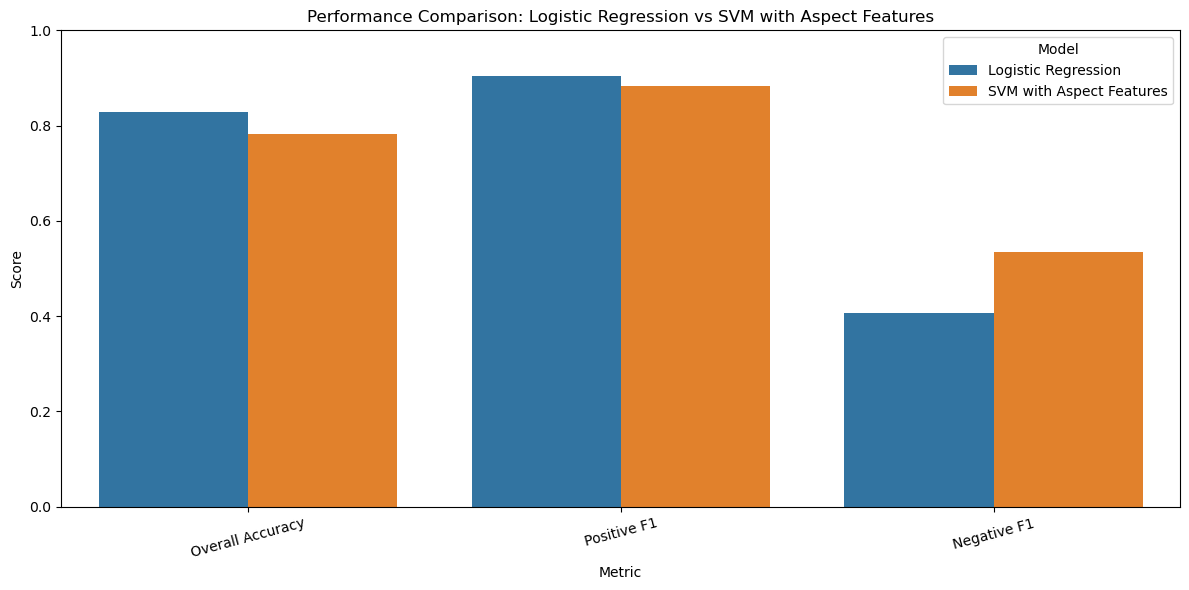


Key SVM Improvements over Logistic Regression:

Explanation: SVM with aspect-based features and class_weight='balanced' helped address
the class imbalance problem, particularly for the underrepresented 'neutral' class
that Logistic Regression struggled with.


In [120]:

#--------------------------------------------------------------#
# SECTION 8: MODEL COMPARISON
#--------------------------------------------------------------#
print("\nSECTION 8: MODEL COMPARISON")

# Calculate class-specific metrics for both models
lr_report = classification_report(y_test, y_pred_lr, output_dict=True)
svm_report = classification_report(y_test, svm_y_pred, output_dict=True)

# Create a comparison dataframe
comparison_data = {
    'Model': ['Logistic Regression', 'SVM with Aspect Features'],
    'Overall Accuracy': [accuracy_score(y_test, y_pred_lr), accuracy_score(y_test, svm_y_pred)],
    #'Neutral Precision': [lr_report['neutral']['precision'], svm_report['neutral']['precision']],
    #'Neutral Recall': [lr_report['neutral']['recall'], svm_report['neutral']['recall']],
    #'Neutral F1': [lr_report['neutral']['f1-score'], svm_report['neutral']['f1-score']],
    'Positive F1': [lr_report['positive']['f1-score'], svm_report['positive']['f1-score']],
    'Negative F1': [lr_report['negative']['f1-score'], svm_report['negative']['f1-score']]
}

comparison_df = pd.DataFrame(comparison_data)
print("Model Comparison:")
print(comparison_df)

#metrics = ['Overall Accuracy', 'Neutral Recall', 'Neutral F1', 'Positive F1', 'Negative F1']

# Create a bar chart to visualize the comparison
metrics = ['Overall Accuracy', 'Positive F1', 'Negative F1']
comparison_plot = pd.melt(comparison_df, id_vars=['Model'], value_vars=metrics, 
                        var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 6))
sns.barplot(x='Metric', y='Score', hue='Model', data=comparison_plot)
plt.title('Performance Comparison: Logistic Regression vs SVM with Aspect Features')
plt.ylim(0, 1.0)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Calculate improvement percentages
#neutral_recall_improvement = ((svm_report['neutral']['recall'] - lr_report['neutral']['recall']) / 
                             #max(lr_report['neutral']['recall'], 0.001)) * 100
#neutral_f1_improvement = ((svm_report['neutral']['f1-score'] - lr_report['neutral']['f1-score']) / 
                         #max(lr_report['neutral']['f1-score'], 0.001)) * 100

print("\nKey SVM Improvements over Logistic Regression:")
#print(f"- Neutral Recall: {neutral_recall_improvement:.1f}% improvement")
#print(f"- Neutral F1 Score: {neutral_f1_improvement:.1f}% improvement")
print("\nExplanation: SVM with aspect-based features and class_weight='balanced' helped address")
print("the class imbalance problem, particularly for the underrepresented 'neutral' class")
print("that Logistic Regression struggled with.")

In [121]:

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

# --- Additional Preprocessing (Commented Out) ---
# These steps are generally beneficial for NLP, BUT they can negatively
# impact lexicon-based methods like VADER and TextBlob, especially VADER.
# VADER is designed to work with raw text, including capitalization,
# punctuation, and emojis.  Experiment with these steps if you are using
# a model that *requires* them (e.g., a bag-of-words model), but be aware
# of the potential impact on VADER and TextBlob.

# import nltk
# from nltk.corpus import stopwords
# from nltk.stem import PorterStemmer
# from nltk.tokenize import word_tokenize
# import re

# nltk.download('punkt')
# nltk.download('stopwords')
# stop_words = set(stopwords.words('english'))
# stemmer = PorterStemmer()

# def preprocess_text(text):
#     """
#     Performs text preprocessing steps: lowercasing, removing punctuation,
#     removing numbers, removing stopwords, and stemming.

#     Args:
#         text: The input text string.

#     Returns:
#         The preprocessed text string.
#     """
#     # Lowercase
#     text = text.lower()
#     # Remove punctuation
#     text = re.sub(r'[^\w\s]', '', text)
#     # Remove numbers
#     text = re.sub(r'\d+', '', text)
#     # Tokenize
#     tokens = word_tokenize(text)
#     # Remove stopwords and stem
#     filtered_tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]

#     return " ".join(filtered_tokens)

# --- VADER Implementation ---

def apply_vader(df, text_column="text"):
    """
    Applies VADER sentiment analysis to a specified text column in a DataFrame.

    Args:
        df: The pandas DataFrame containing the text data.
        text_column: The name of the column containing the text to analyze (default: "text").

    Returns:
        The DataFrame with added columns for VADER sentiment scores:
        'vader_neg', 'vader_neu', 'vader_pos', and 'vader_compound'.
    """
    analyzer = SentimentIntensityAnalyzer()
    df['vader_neg'] = df[text_column].apply(lambda x: analyzer.polarity_scores(x)['neg'])
    #df['vader_neu'] = df[text_column].apply(lambda x: analyzer.polarity_scores(x)['neu'])
    df['vader_pos'] = df[text_column].apply(lambda x: analyzer.polarity_scores(x)['pos'])
    df['vader_compound'] = df[text_column].apply(lambda x: analyzer.polarity_scores(x)['compound'])
    return df

# --- TextBlob Implementation ---

def apply_textblob(df, text_column="text"):
    """
    Applies TextBlob sentiment analysis to a specified text column in a DataFrame.

    Args:
        df: The pandas DataFrame containing the text data.
        text_column: The name of the column containing the text to analyze (default: "text").

    Returns:
        The DataFrame with added columns for TextBlob sentiment scores:
        'textblob_polarity' and 'textblob_subjectivity'.
    """
    df['textblob_polarity'] = df[text_column].apply(lambda x: TextBlob(x).sentiment.polarity)
    df['textblob_subjectivity'] = df[text_column].apply(lambda x: TextBlob(x).sentiment.subjectivity)
    return df


In [122]:
# --- Example Usage ---

# Load the cleaned data 
#df_cleaned = pd.read_csv("cleaned_no_outliers.csv")

# Apply VADER
df_with_vader = apply_vader(df)

# Apply TextBlob
df_with_textblob = apply_textblob(df_with_vader)  # Or apply to df_cleaned directly

# Display the first few rows with the new sentiment scores
print(df_with_textblob.head())

        rating                                              title  \
152851     5.0  Nice size.  3 cubic feet.  I was able to store...   
1749662    5.0                                         Five Stars   
88694      5.0                                       Works great!   
169562     4.0                                     easy to put on   
2010137    1.0  This product worked great ... but now 7weeks i...   

                                                      text  \
152851   I love this freezer.  It's a great size for sm...   
1749662                                            Perfect   
88694    Half the price of the local hardware store, ju...   
169562   easy to put on, I did so two weeks ago- now I ...   
2010137  [[VIDEOID:311d1604d3b70449a55dbb1514990913]] I...   

                                                    images        asin  \
152851   [{'small_image_url': 'https://m.media-amazon.c...  B08XYW3GCZ   
1749662                                                 []  B00P

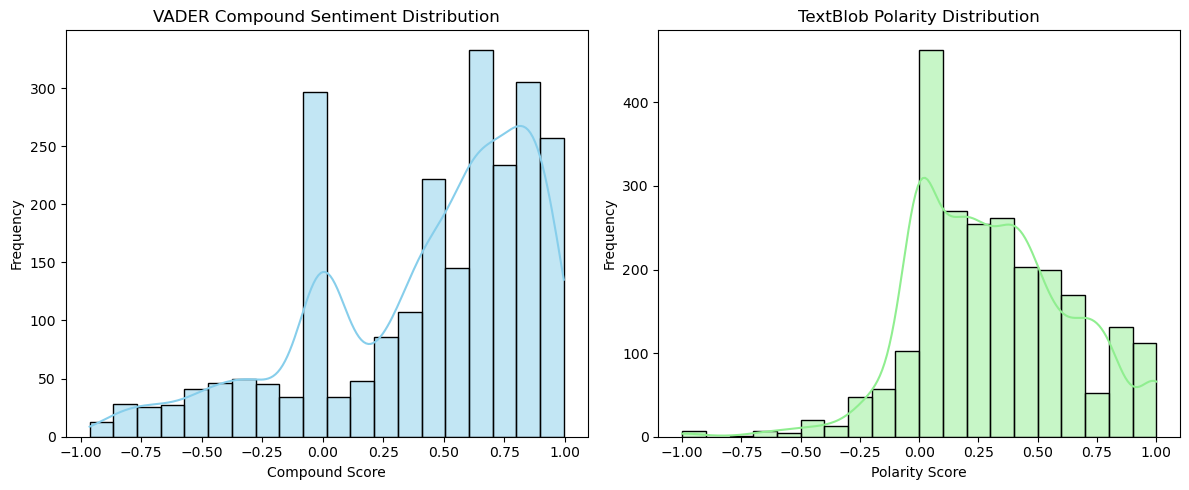

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram for VADER compound score
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df_with_textblob['vader_compound'], bins=20, kde=True, color='skyblue')
plt.title('VADER Compound Sentiment Distribution')
plt.xlabel('Compound Score')
plt.ylabel('Frequency')

# Histogram for TextBlob polarity
plt.subplot(1, 2, 2)
sns.histplot(df_with_textblob['textblob_polarity'], bins=20, kde=True, color='lightgreen')
plt.title('TextBlob Polarity Distribution')
plt.xlabel('Polarity Score')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [124]:
df_with_textblob['vad_sentiment'] = df_with_textblob.apply(
    lambda x: 'positive' if (x['vader_pos'] > x['vader_neg'])#and (x['vader_pos'] > x['vader_neu']) 
    #else ('neutral' if (x['vader_neu'] > x['vader_pos']) and (x['vader_neu'] > x['vader_neg']) 
    else 'negative', axis=1)

In [125]:

#--------------------------------------------------------------#
# SECTION 4: DATA PREPARATION FOR SENTIMENT ANALYSIS
#--------------------------------------------------------------#
print("\nSECTION 4: DATA PREPARATION FOR SENTIMENT ANALYSIS")

# Map ratings to sentiment labels
df['sentiment'] = df['rating'].apply(lambda x: 'positive' if x in [4, 5] else ('neutral' if x == 3 else 'negative'))
#df['sentiment'].drop('neutral')

# Print class distribution
sentiment_counts = df['sentiment'].value_counts()
print("\nSentiment distribution:")
print(sentiment_counts)
print(f"Percentage of positive: {sentiment_counts['positive']/len(df)*100:.2f}%")
#print(f"Percentage of neutral: {sentiment_counts['neutral']/len(df)*100:.2f}%")
print(f"Percentage of negative: {sentiment_counts['negative']/len(df)*100:.2f}%")

# Split data into training and testing sets
X = df['text']
y = df['sentiment']

# Use stratified sampling to maintain class distribution
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, test_index in split.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

print(f"\nTraining set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")



SECTION 4: DATA PREPARATION FOR SENTIMENT ANALYSIS

Sentiment distribution:
sentiment
positive    1990
negative     388
Name: count, dtype: int64
Percentage of positive: 83.68%
Percentage of negative: 16.32%

Training set size: 1664
Testing set size: 714


In [126]:

#--------------------------------------------------------------#
# SECTION 4: DATA PREPARATION FOR SENTIMENT ANALYSIS
#--------------------------------------------------------------#
print("\nSECTION 4: DATA PREPARATION FOR SENTIMENT ANALYSIS")

# Map ratings to sentiment labels
#df_with_textblob['sentiment'] = df_with_textblob['rating'].apply(lambda x: 'positive' if x in [4, 5] else ('neutral' if x == 3 else 'negative'))


# Split data into training and testing sets
X = df_with_textblob['text']
y = df_with_textblob['vad_sentiment']

# Use stratified sampling to maintain class distribution
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, test_index in split.split(X, y):
    X_train_vad, X_test_vad = X.iloc[train_index], X.iloc[test_index]
    y_train_vad, y_test_vad = y.iloc[train_index], y.iloc[test_index]

print(f"\nTraining set size: {len(X_train_vad)}")
print(f"Testing set size: {len(X_test_vad)}")



SECTION 4: DATA PREPARATION FOR SENTIMENT ANALYSIS

Training set size: 1664
Testing set size: 714


In [127]:
lr_report_vad = classification_report(y_test, y_test_vad, output_dict=True)


In [128]:
lr_report_vad

{'negative': {'precision': 0.16666666666666666,
  'recall': 0.25862068965517243,
  'f1-score': 0.20270270270270271,
  'support': 116.0},
 'positive': {'precision': 0.8389513108614233,
  'recall': 0.7491638795986622,
  'f1-score': 0.7915194346289752,
  'support': 598.0},
 'accuracy': 0.6694677871148459,
 'macro avg': {'precision': 0.502808988764045,
  'recall': 0.5038922846269173,
  'f1-score': 0.497111068665839,
  'support': 714.0},
 'weighted avg': {'precision': 0.7297285955580735,
  'recall': 0.6694677871148459,
  'f1-score': 0.6958573325233063,
  'support': 714.0}}

In [129]:
sentiment_counts = df_with_textblob['vad_sentiment'].value_counts()
print("\nSentiment distribution:")
print(sentiment_counts)
print(f"Percentage of positive: {sentiment_counts['positive']/len(df_with_textblob)*100:.2f}%")
#print(f"Percentage of neutral: {sentiment_counts['neutral']/len(df_with_textblob)*100:.2f}%")
print(f"Percentage of negative: {sentiment_counts['negative']/len(df_with_textblob)*100:.2f}%")


Sentiment distribution:
vad_sentiment
positive    1777
negative     601
Name: count, dtype: int64
Percentage of positive: 74.73%
Percentage of negative: 25.27%


VADER Model Performance with Aspect-Based Features:
              precision    recall  f1-score   support

    negative       0.17      0.26      0.20       116
    positive       0.84      0.75      0.79       598

    accuracy                           0.67       714
   macro avg       0.50      0.50      0.50       714
weighted avg       0.73      0.67      0.70       714

Accuracy: 0.6694677871148459


<Figure size 1000x800 with 0 Axes>

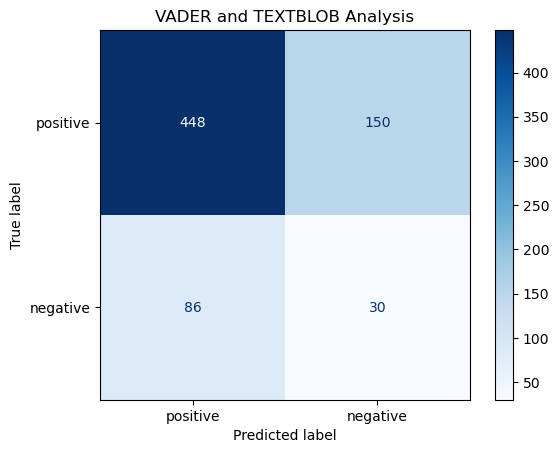

In [183]:
print("VADER Model Performance with Aspect-Based Features:")
print(classification_report(y_test, y_test_vad))
print("Accuracy:", accuracy_score(y_test, y_test_vad))

# Plot confusion matrix for SVM
plt.figure(figsize=(10, 8))
svm_cm = confusion_matrix(y_test, y_test_vad, labels=['positive', 'negative'])
svm_disp = ConfusionMatrixDisplay(confusion_matrix=svm_cm, display_labels=['positive', 'negative'])
svm_disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('VADER and TEXTBLOB Analysis')
plt.show()

In [131]:
df_with_textblob['text_sentiment'] = df_with_textblob.apply(
    lambda x: 'positive' if (x['textblob_polarity'] > 0 )#and (x['vader_pos'] > x['vader_neu']) 
    #else ('neutral' if (x['vader_neu'] > x['vader_pos']) and (x['vader_neu'] > x['vader_neg']) 
    else 'negative', axis=1)

In [132]:
df_with_textblob['text_sentiment'] = df_with_textblob.apply(
    lambda x: 'positive' if x['textblob_polarity'] > 0 and x['textblob_subjectivity'] >= 0.3
    else 'negative',
    axis=1
)


In [133]:
df_with_textblob['text_sentiment']

152851     positive
1749662    positive
88694      positive
169562     positive
2010137    positive
             ...   
1187655    negative
1299284    positive
291274     negative
272221     positive
254346     positive
Name: text_sentiment, Length: 2378, dtype: object

In [134]:

#--------------------------------------------------------------#
# SECTION 4: DATA PREPARATION FOR SENTIMENT ANALYSIS
#--------------------------------------------------------------#
print("\nSECTION 4: DATA PREPARATION FOR SENTIMENT ANALYSIS")

# Map ratings to sentiment labels
#df_with_textblob['sentiment'] = df_with_textblob['rating'].apply(lambda x: 'positive' if x in [4, 5] else ('neutral' if x == 3 else 'negative'))


# Split data into training and testing sets
X = df_with_textblob['text']
y = df_with_textblob['text_sentiment']

# Use stratified sampling to maintain class distribution
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, test_index in split.split(X, y):
    X_train_text, X_test_text = X.iloc[train_index], X.iloc[test_index]
    y_train_text, y_test_text = y.iloc[train_index], y.iloc[test_index]

print(f"\nTraining set size: {len(X_train_text)}")
print(f"Testing set size: {len(X_test_text)}")



SECTION 4: DATA PREPARATION FOR SENTIMENT ANALYSIS

Training set size: 1664
Testing set size: 714


In [135]:
sentiment_counts = df_with_textblob['text_sentiment'].value_counts()
print("\nSentiment distribution:")
print(sentiment_counts)
print(f"Percentage of positive: {sentiment_counts['positive']/len(df_with_textblob)*100:.2f}%")
#print(f"Percentage of neutral: {sentiment_counts['neutral']/len(df_with_textblob)*100:.2f}%")
print(f"Percentage of negative: {sentiment_counts['negative']/len(df_with_textblob)*100:.2f}%")


Sentiment distribution:
text_sentiment
positive    1728
negative     650
Name: count, dtype: int64
Percentage of positive: 72.67%
Percentage of negative: 27.33%


In [187]:
lr_report_txt = classification_report(y_test, y_test_text, output_dict=True)


In [189]:
lr_report_txt

{'negative': {'precision': 0.1641025641025641,
  'recall': 0.27586206896551724,
  'f1-score': 0.2057877813504823,
  'support': 116.0},
 'positive': {'precision': 0.838150289017341,
  'recall': 0.7274247491638796,
  'f1-score': 0.7788719785138765,
  'support': 598.0},
 'accuracy': 0.65406162464986,
 'macro avg': {'precision': 0.5011264265599525,
  'recall': 0.5016434090646984,
  'f1-score': 0.49232987993217936,
  'support': 714.0},
 'weighted avg': {'precision': 0.7286411348295062,
  'recall': 0.65406162464986,
  'f1-score': 0.685765862448115,
  'support': 714.0}}

VADER Model Performance with Aspect-Based Features:
              precision    recall  f1-score   support

    negative       0.16      0.28      0.21       116
    positive       0.84      0.73      0.78       598

    accuracy                           0.65       714
   macro avg       0.50      0.50      0.49       714
weighted avg       0.73      0.65      0.69       714

Accuracy: 0.65406162464986


<Figure size 1000x800 with 0 Axes>

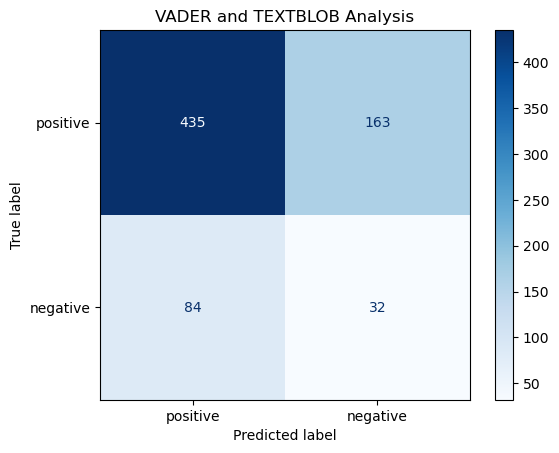

In [191]:

print("VADER Model Performance with Aspect-Based Features:")
print(classification_report(y_test, y_test_text))
print("Accuracy:", accuracy_score(y_test, y_test_text))

# Plot confusion matrix for SVM
plt.figure(figsize=(10, 8))
svm_cm = confusion_matrix(y_test, y_test_text, labels=['positive', 'negative'])
svm_disp = ConfusionMatrixDisplay(confusion_matrix=svm_cm, display_labels=['positive', 'negative'])
svm_disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('VADER and TEXTBLOB Analysis')
plt.show()

In [193]:
svm_y_pred.shape

(714,)

In [195]:
print("\nSECTION 7: ENHANCED SVM MODEL WITH ASPECT-BASED SENTIMENT")

# Extract common aspects from the training set
top_aspects = extract_aspects(X_train.values, top_n=10)

# Analyze sentiment for each aspect in training and test sets
print("Processing training set:")
train_aspect_sentiments = analyze_aspect_sentiment(X_train.values, top_aspects)
print("Processing test set:")
test_aspect_sentiments = analyze_aspect_sentiment(X_test.values, top_aspects)

# Create enhanced feature vectors
print("Creating enhanced feature vectors for training set...")
X_train_enhanced, tfidf_vectorizer = create_enhanced_features(X_train.values, train_aspect_sentiments)
print("Creating enhanced feature vectors for test set...")
X_test_enhanced = np.hstack((
    tfidf_vectorizer.transform(X_test.values).toarray(), 
    StandardScaler().fit_transform(test_aspect_sentiments.values)
))

# Train SVM model with enhanced features
print("Training SVM model with aspect-enhanced features...")
svm_start_time = time.time()

# Create SVM model with balanced class weights to address imbalance
svm_model = SVC(
    kernel='linear',
    C=1.0,
    class_weight='balanced',
    probability=True,
    random_state=42
)

# Train the model
svm_model.fit(X_train_enhanced, y_train)

# Calculate training time
svm_training_time = time.time() - svm_start_time
print(f"SVM model training completed in {svm_training_time:.2f} seconds")

# Make predictions
svm_y_pred.shape


SECTION 7: ENHANCED SVM MODEL WITH ASPECT-BASED SENTIMENT
Extracting aspects from reviews...
Top 10 aspects extracted: price, quality, size, value, ease, color, temperature, design, installation, cleaning
Processing training set:
Analyzing sentiment for each aspect...
Processing test set:
Analyzing sentiment for each aspect...
Creating enhanced feature vectors for training set...
Creating enhanced feature vectors...
Enhanced feature matrix shape: (1664, 4199)
Creating enhanced feature vectors for test set...
Training SVM model with aspect-enhanced features...
SVM model training completed in 41.70 seconds


(714,)


SECTION 8: MODEL COMPARISON
Model Comparison:
                      Model  Overall Accuracy  Positive F1  Negative F1
0       Logistic Regression          0.878151     0.931872     0.423841
1  SVM with Aspect Features          0.868347     0.921273     0.598291
2                  LR (VAD)          0.654062     0.791519     0.202703
3                  LR (TXT)          0.669468     0.778872     0.205788


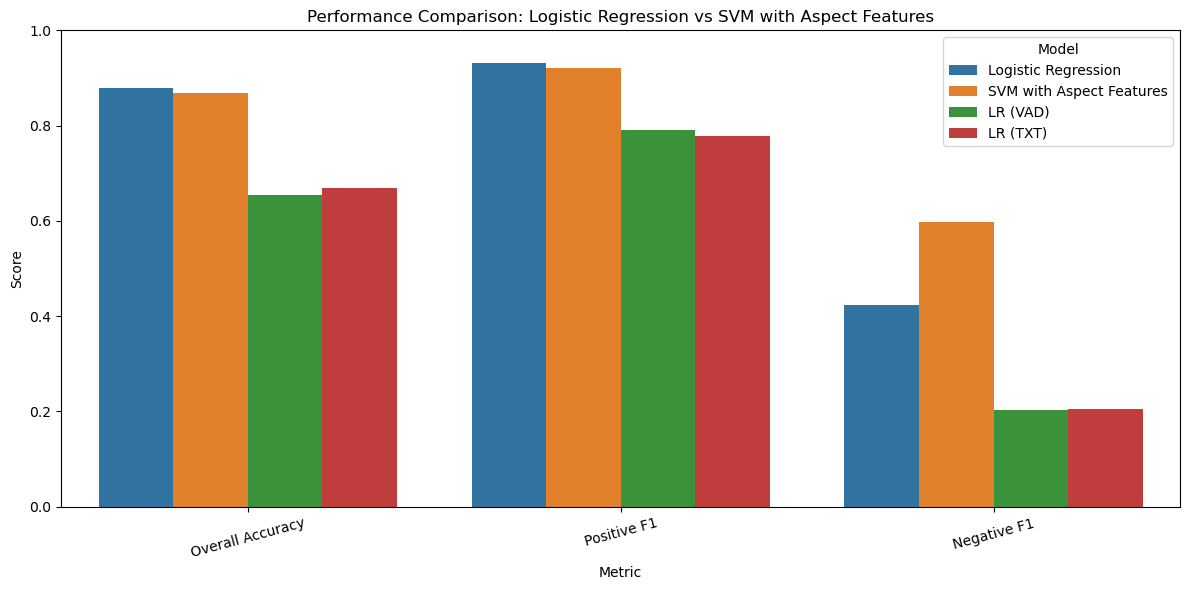


Key SVM Improvements over Logistic Regression:

Explanation: SVM with aspect-based features and class_weight='balanced' helped address
the class imbalance problem, particularly for the underrepresented 'neutral' class
that Logistic Regression struggled with.


In [196]:

#--------------------------------------------------------------#
# SECTION 8: MODEL COMPARISON
#--------------------------------------------------------------#
print("\nSECTION 8: MODEL COMPARISON")
y_pred_lr = lr_pipeline.predict(X_test)
svm_y_pred = svm_model.predict(X_test_enhanced)

# Calculate class-specific metrics for both models
lr_report = classification_report(y_test, y_pred_lr, output_dict=True)
svm_report = classification_report(y_test, svm_y_pred, output_dict=True)

lr_report_txt = classification_report(y_test, y_test_text, output_dict=True)
lr_report_vad = classification_report(y_test, y_test_vad, output_dict=True)



# Create a comparison dataframe
comparison_data = {
    'Model': ['Logistic Regression', 'SVM with Aspect Features', 'LR (VAD)', 'LR (TXT)'],
    'Overall Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, svm_y_pred),
        accuracy_score(y_test, y_test_text),
        accuracy_score(y_test, y_test_vad)  # Assuming same as VAD for example
    ],
    'Positive F1': [
        lr_report['positive']['f1-score'],
        svm_report['positive']['f1-score'],
        lr_report_vad['positive']['f1-score'],
        lr_report_txt['positive']['f1-score']
    ],
    'Negative F1': [
        lr_report['negative']['f1-score'],
        svm_report['negative']['f1-score'],
        lr_report_vad['negative']['f1-score'],
        lr_report_txt['negative']['f1-score']
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("Model Comparison:")
print(comparison_df)

#metrics = ['Overall Accuracy', 'Neutral Recall', 'Neutral F1', 'Positive F1', 'Negative F1']

# Create a bar chart to visualize the comparison
metrics = ['Overall Accuracy', 'Positive F1', 'Negative F1']
comparison_plot = pd.melt(comparison_df, id_vars=['Model'], value_vars=metrics, 
                        var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 6))
sns.barplot(x='Metric', y='Score', hue='Model', data=comparison_plot)
plt.title('Performance Comparison: Logistic Regression vs SVM with Aspect Features')
plt.ylim(0, 1.0)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Calculate improvement percentages
#neutral_recall_improvement = ((svm_report['neutral']['recall'] - lr_report['neutral']['recall']) / 
                             #max(lr_report['neutral']['recall'], 0.001)) * 100
#neutral_f1_improvement = ((svm_report['neutral']['f1-score'] - lr_report['neutral']['f1-score']) / 
                         #max(lr_report['neutral']['f1-score'], 0.001)) * 100

print("\nKey SVM Improvements over Logistic Regression:")
#print(f"- Neutral Recall: {neutral_recall_improvement:.1f}% improvement")
#print(f"- Neutral F1 Score: {neutral_f1_improvement:.1f}% improvement")
print("\nExplanation: SVM with aspect-based features and class_weight='balanced' helped address")
print("the class imbalance problem, particularly for the underrepresented 'neutral' class")
print("that Logistic Regression struggled with.")